<a href="https://colab.research.google.com/github/adriansuder/chapter_dotNET/blob/main/Chapter_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#.NET Secret Manager

## Krótko o user secrets

**.NET Secret Manager** to narzędzie do bezpiecznego przechowywania poufnych danych (takich jak klucze API lub hasła) w lokalnej bazie danych podczas tworzenia aplikacji .NET. Zapewnia, że te dane nie są zapisywane w kodzie źródłowym projektu ani nie są dodawane do systemu kontroli wersji, bo jak wiemy wrzucanie secretów do appsettingsa to totalny antypattern. Informacje te są przechowywane w osobnym pliku JSON w katalogu profilu użytkownika, a nie w drzewie projektu.

Lokalizacja pliku z secretami: **%APPDATA%\Roaming\Microsoft\UserSecrets\GUID_Z_CSPROJA\secrets.json**

**Co ważne - secret manager dodajemy per projekt - a nie solucję**

##Jak to działa

### Inicjalizacja



Na start jedna osoba z projektu dodaje secret managera do projektu
    Wywołuje w terminalu (będąc w ścieżce tam gdzie znajduje się .csproj komendę
`dotnet user-secrets init`
po tym do naszego csproja trafia nowy tag `<UserSecretsId>GUID</UserSecretsId>`
a tym samym zostaje utworzony folder powiązany z tym GUIDem. Po utworzeniu pierwszego secreta zostanie utworzony plik secrets.json

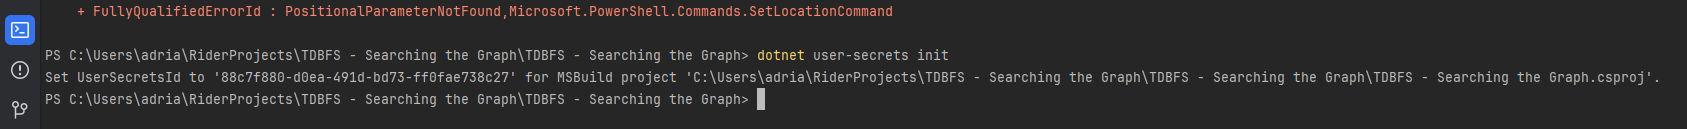


### Dodanie secretów


Aby dodać secrety do danego secret managera z terminala z poziomu csproja (tak by nie wskazywać ręcznie csproja) wywołujemy `dotnet user-secrets set "ConnectionStrings:db" "Host=LOCALHOST; Port=5432; Username=np_nasze_CK; Password=superSilneHasło"`


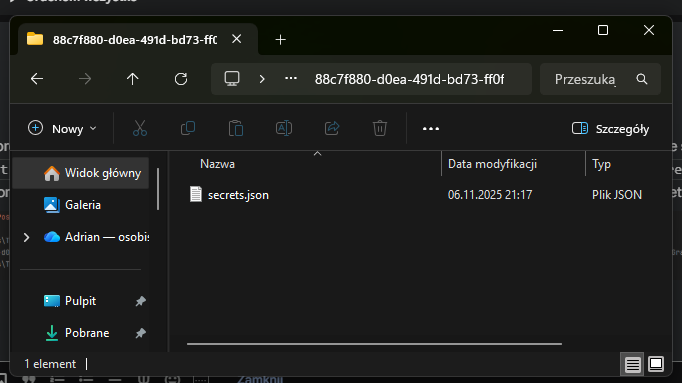


a wewnątrz pliku

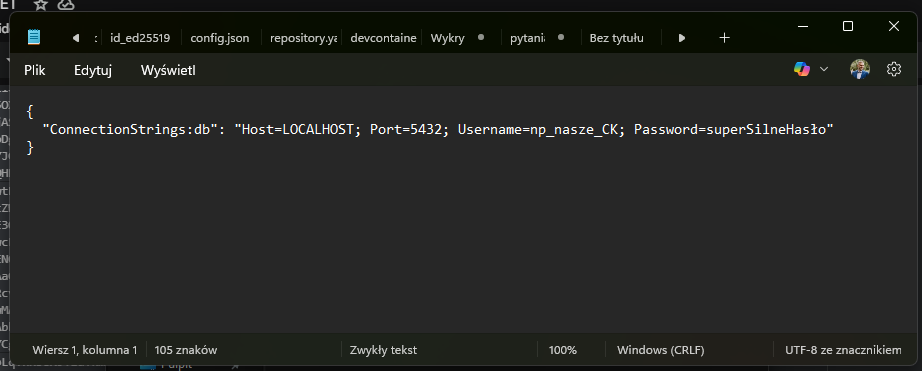

### Użycie w kodzie

I cały myk w tym jest taki, że wszystko dzieje się automatycznie DefaultBuilder sam wstrzykuje secrets.json i nie trzeba nic dodatkowo robić by móc odczytać te wartości.

Ale co ważne! Zmienna **ASPNETCORE_ENVIRONMENT** musi mieć wartość **Development** inaczej secrety na pewno się nie załadują. Np w FINGu zmienne te przyjmują w zależności od launchSettingsa rózne wartości np local, dev, uat i na tej podstawie ładuje się appsettgs.env.json. W tym wypadku secrets.json nigdy się nie załaduje i w takim w razie zawsze można użyc np:

```
var builder = WebApplication.CreateBuilder(args);

// Ręczne dodanie User Secrets, jeśli środowisko to "LOCAL"
if (builder.Environment.IsEnvironment("LOCAL"))
{
    // To załaduje sekrety powiązane z tym projektem
    builder.Configuration.AddUserSecrets(typeof(Program).Assembly, optional: true);
}
```



### Jak to zrobić bez większych zmian w kodzie

Dla naszego ConnStringa dodajemy całego stringa wraz z hostem, portem, hasłem i userem. Niby działa, ale jeżeli ktoś dużo się przepina np między dev a uat to mało wygodne fajnie jakby jednak wpisać tylko user i pass i nie martwić się o zmianę środowiska

### Jak wg mnie byłoby fantastycznie na przykładzie FINGa i z rozpędu już z postgresowym connectorem ;)

Poniżej kawałek kodu, który jest najbardziej uniwersalny. Uzupełniamy same username i password

(pseudo kod, bo nie spradzałem czy działa i czy składnia jest poprawna) pomijam fakt, że przykład jest tylko z program.cs, a my nadal mamy program.cs startup.cs




```
var builder = WebApplication.CreateBuilder(args);
string baseConnectionString = builder.Configuration.GetConnectionString("db");

if (builder.Environment.IsEnvironment("local") ||
    builder.Environment.IsEnvironment("DEV") ||
    builder.Environment.IsEnvironment("UAT"))
{
    // To załaduje sekrety powiązane z tym projektem
    builder.Configuration.AddUserSecrets(typeof(Program).Assembly, optional: true);
}

var npgsqlBuilder = new NpgsqlConnectionStringBuilder(baseConnectionString);

string dbUser = builder.Configuration["Database:User"];
string dbPassword = builder.Configuration["Database:Password"];

if (string.IsNullOrEmpty(dbUser) || string.IsNullOrEmpty(dbPassword))
{
    throw new InvalidOperationException("Nie można odnaleźć sekretów 'Database:User' i 'Database:Password'. " +
        "Upewnij się, że ustawiłeś je za pomocą 'dotnet user-secrets set'.");
}

npgsqlBuilder.Username = dbUser;
npgsqlBuilder.Password = dbPassword;

string finalConnectionString = npgsqlBuilder.ConnectionString;

//FinalnyConnectionString
builder.Services.AddDbContext<ApplicationDbContext>(options =>
    options.UseNpgsql(finalConnectionString));

var app = builder.Build();

```



# Przejście z MS SQL na PostgreSQL a poziom izolacji ReadCommited na przykładzie FING i ostatnich rozkminek w związku z transakcjami

## Każdy wie jak działają transakcje?

Transakcja jako "umowa" z bazą danych, która gwarantuje, że zestaw operacji (np. pobranie pieniędzy z jednego konta i dodanie na drugie) wykona się w całości albo wcale.

Fundamentem umowy są zasady ACID:

A – Atomicity (Atomowość): "Wszystko albo nic". Nie może być tak, że operacja się uda tylko "w połowie". Jeśli przelewasz pieniądze, nie mogą one zniknąć z pierwszego konta, jeśli nie pojawią się na drugim.

C – Consistency (Spójność): Transakcja zawsze przeprowadza bazę danych z jednego poprawnego stanu w drugi poprawny stan. (Np. sumy na kontach muszą się zgadzać przed i po).

I – Isolation (Izolacja): To jest kluczowy punkt dla Twojej prezentacji! Izolacja gwarantuje, że transakcje działające jednocześnie (współbieżnie) nie widzą swoich "brudnych" lub niekompletnych zmian. Poziomy izolacji (jak Read Committed) definiują, jak bardzo transakcje są od siebie odizolowane.

D – Durability (Trwałość): Gdy baza powie "OK, zrobione" (COMMIT), zmiana jest trwała. Musi przetrwać awarię zasilania, serwera itp.

Mechanika Działania w uproszczeniu
Kiedy prosisz sqla o wykonanie transakcji (BEGIN TRAN ..PITU PITU JAKIEŚ UPDATE.... COMMIT), pod spodem dzieją się dwie kluczowe rzeczy:


1. Dziennik Transakcyjny (Transaction Log) - A i D
Zanim MS SQL w ogóle dotknie właściwych danych w tabeli, najpierw zapisuje co zamierza zrobić w specjalnym pliku – Dzienniku Transakcyjnym.

Jak działa: Mówi: "Zamierzam zmienić rekord X z wartości A na B".

Dlaczego?

Dla Trwałości (D): Jeśli serwer padnie tuż po tym, jak zapisał to w logu (ale zanim zmienił dane w tabeli), po restarcie przeczyta log i "dokończy" robotę.

Dla Atomowości (A): Jeśli transakcja się nie uda (albo powiesz ROLLBACK), SQL Server patrzy w log i wykonuje operacje odwrotne, aby cofnąć wszystkie zmiany.

2. Menedżer Blokad (Lock Manager) - I
Kiedy transakcja potrzebuje danych, musi "poprosić" Menedżera Blokad o dostęp.

Jak działa (domyślnie):

Gdy zmieniasz dane (UPDATE, DELETE), Twoja transakcja prosi o blokadę wyłączną (Exclusive Lock, X). Dopóki jej nie zwolnisz (COMMIT lub ROLLBACK), nikt inny nie może tych danych ani czytać, ani modyfikować. Chyba, że dorzuci WITH NO LOCK ;)

Gdy czytasz dane, transakcja prosi o blokadę współdzieloną (Shared Lock, S). Inni mogą te dane też czytać (też dostaną blokadę S), ale nikt nie może ich w tym czasie zmienić (bo nie dostanie blokady X).

## Poziomy izolacji

#### *dirty read, non-repeatable read, phatnom read

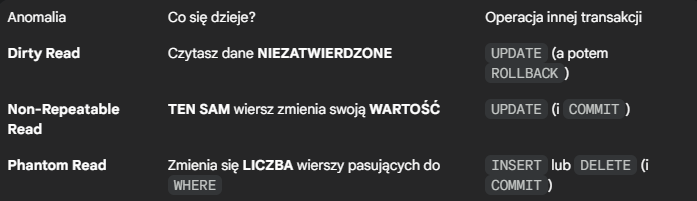

#### READ UNCOMMITED


To najniższy i "najbrudniejszy" poziom. Mówi bazie: "Nie obchodzą mnie blokady, po prostu daj mi dane". SELECT nie zakłada żadnych blokad i ignoruje blokady innych.

Efekt: Odczytujesz dane, które inna transakcja właśnie zmienia, ale których jeszcze nie zatwierdziła (COMMIT).

Problemy, które dopuszcza:

Dirty Reads: TAK.

Non-Repeatable Reads: TAK.

Phantom Reads: TAK.

#### READ COMMITED (Domyślny poziom w MS SQL i PostgreSQL, ale z małym haczykiem)

Wariant A: Domyślne READ COMMITTED (z blokowaniem) RCSI* wyłączone
Co robi: SELECT zakłada blokady współdzielone na odczytywany wiersz, ale zwalnia je natychmiast po jego odczytaniu (nie trzyma ich do końca transakcji).

Problemy, które rozwiązuje:
Dirty Reads: nie odczytasz już niezatwierdzonych zmian, bo SELECT poczeka na zwolnienie blokady X przez piszącego.

Problemy, które dopuszcza:

Non-Repeatable Reads: TAK. (Czytasz wiersz, zwalniasz blokadę. Ktoś inny go zmienia i zatwierdza. Czytasz go ponownie w tej samej transakcji i... masz inną wartość).

Phantom Reads: TAK.

Główny problem: wzajemne blokowanie read'ów i write'ów!

Wariant B: READ COMMITTED SNAPSHOT ISOLATION (RCSI)
Co robi: To nie jest oddzielny poziom, ale zmiana zachowania READ COMMITTED na poziomie całej bazy (ALTER DATABASE ... SET READ_COMMITTED_SNAPSHOT ON).

Jak działa: SELECT nie zakłada żadnych blokad. Zamiast tego, jeśli trafi na wiersz blokowany przez piszącego, odczytuje jego ostatnią zatwierdzoną wersję (snapshot) z tempdb.

**Problemy, które rozwiązuje:**

Dirty Reads: TAK.

BLOKOWANIE: TAK (To jest jego główny cel).

**Problemy, które dopuszcza:**

Non-Repeatable Reads: TAK. (Działa tak samo jak domyślny - migawka jest brana na poziomie pojedynczego zapytania, nie całej transakcji).

Phantom Reads: TAK.

### REPEATABLE READ

SELECT zakłada blokady współdzielone (S) na wszystkie odczytane wiersze i trzyma je **aż do końca transakcji** (COMMIT/ROLLBACK).

**Problemy, które rozwiązuje:**

Dirty Reads: TAK.

Non-Repeatable Reads: TAK. (Ponieważ trzymasz blokadę S na wierszu, nikt inny nie może go zmienić, dopóki nie skończysz transakcji).

**Problemy, które dopuszcza:**
Phantom Reads: TAK.

### SNAPSHOT ISOLATION

Działa podobnie do RCSI, ale na poziomie całej transakcji. Kiedy transakcja startuje, widzi spójny snapshot bazy danych z momentu jej rozpoczęcia. Pracuje na tych danych (przechowywanych w tempdb).

**Problemy, które rozwiązuje:**

Dirty Reads: TAK.

Non-Repeatable Reads: TAK.

Phantom Reads: TAK.

Główny problem: "Update Conflicts". Jeśli Ty (w transakcji A) próbujesz zmienić wiersz, który ktoś inny (transakcja B) zmienił i zatwierdził po tym, jak Ty zacząłeś, Twoja transakcja A zostanie wycofana z błędem. Aplikacja musi być gotowa na powtórzenie takiej transakcji.

### SERIALIZABLE

Najwyższy, najbardziej pesymistyczny poziom. Mówi bazie: "Symuluj, że moja transakcja jest jedyną rzeczą działającą teraz na świecie".

Jak działa: Zakłada blokady na całe zakresy danych, aby zapobiec np Phantom Reads.

**Problemy, które rozwiązuje: Wszystkie ;)**

Główny problem: Ogromne blokowanie. Używane bardzo rzadko. Kojarzy mi się tylko z deadlockami i tragicznie niską współbieżnością ;)




### Odpowiednik RCSI w PostgreSQL MVCC





Dla przypomnienia defaultowo w MS SQL mamy poziom ReadCommited i Snapshot Isolation wyłączony. Natomiast w PGSQL poziom ReadCommited ma Multiversion Concurency Control (Odpowiednik RCSI w ms sql). I cały myk polega na tym, że tego **nie wyłączymy** a jakby nie patrzeć zmienia to zachowanie bazy danych.

### Nawet jeżeli nie używamy wprost transakcji w kodzie, to każde wywołanie SaveChanges wywoływane jest w transakcji